**<h1>GLASSES OR NO GLASSES</h1>**

The aim of this work is to determine if a person is wearing glasses or not, in a supervised way, using neural networks.
The data is available on [www.kaggle.com/jeffheaton/glasses-or-no-glasses](https://) , where there are two datasets of the same 5000 samples provided in two different configurations:
* vectors of 512 numerical features (and binary labels), which have been used to generate the actual images and which we will use to train Multi-Layer Perceptrons;
* 1024x1024 color images, which we will use to train CNNs.

We download the data using the Kaggle API. To do so, replace `KAGGLE_USERNAME` and `KAGGLE_KEY` variables with Kaggle credentials. Then, unzip them.

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxx"                     
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

!kaggle datasets download -d jeffheaton/glasses-or-no-glasses
!unzip -o -q /content/glasses-or-no-glasses.zip

100% 6.11G/6.11G [02:06<00:00, 26.9MB/s]



Once we have the data, we can set all the *seed* variables in order to allow reproducibility.

In [ ]:
seed = 0

os.environ["PYTHONHASHSEED"] = "0"

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)

**<h2>Numerical Dataset</h2>**
<h2>Importing the data</h2>

Training and Test set are separately provided in two different `.csv` files. As we have already downloaded and unzipped them, we can easily import them as `pandas.DataFrame`. After that, we prefer to merge them, preprocess data and then create our personal splits in a second moment.

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

df = pd.concat([train_df, test_df], ignore_index=True)
df

,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v474,v475,v476,v477,v478,v479,v480,v481,v482,v483,v484,v485,v486,v487,v488,v489,v490,v491,v492,v493,v494,v495,v496,v497,v498,v499,v500,v501,v502,v503,v504,v505,v506,v507,v508,v509,v510,v511,v512,glasses
0,1,0.37797,-0.94808,0.01346,0.17893,0.37795,0.63571,0.13943,-0.25607,-0.39341,1.08947,-1.36048,-1.31529,0.36119,-0.62857,-1.65290,1.47167,-0.88741,-0.25942,-0.34414,-0.38914,0.38425,-0.50553,-0.09451,0.30568,-1.07570,-0.65924,1.10918,1.22234,-0.12479,0.50198,-0.63932,0.61505,1.16747,0.36921,-0.44398,0.46192,-0.83207,-0.74952,-0.40722,...,0.54072,-0.71995,1.11262,-0.11429,0.85618,0.17233,-1.06815,0.04569,-0.13031,2.07549,0.47934,0.69172,1.37139,0.45480,-0.96053,0.06319,0.09664,-0.34749,0.09889,-0.87606,0.82594,0.52841,0.84209,0.16771,0.59003,-0.22960,-0.04017,0.15554,-0.41569,0.68050,-0.03494,1.32443,-0.94570,0.02055,-1.23908,0.43507,1.08635,1.69027,0.61609,0.0
1,2,0.07609,-0.09774,0.39666,-0.39026,0.10606,0.52774,0.07105,0.33720,0.69917,-0.02842,-0.56431,0.42060,-0.47533,1.60025,-0.02106,-2.30193,-0.31614,-0.08050,0.85041,-0.10574,-0.33177,-1.32102,-0.22244,-0.52076,0.40012,-0.41339,-0.15176,1.02155,-0.52834,0.66718,0.54844,0.18323,0.28764,-0.80084,-0.85040,0.45097,0.88317,-1.13375,-1.85301,...,-0.25966,-1.19259,-0.71514,-0.08903,-0.58853,-0.20697,-0.77025,-1.21129,-0.67575,0.32509,-0.35147,-0.33581,-0.31505,-1.66721,0.40666,0.15053,-0.77809,0.35837,-1.10950,0.03764,-0.93728,-0.68952,-0.92334,-0.35401,-1.20552,1.10199,0.46268,0.85954,-0.48484,-0.54585,0.86624,-1.24953,-0.21511,-1.54146,1.04765,-1.24035,0.00866,-1.27640,-0.60496,1.0
2,3,1.19391,-0.68707,-0.68422,-0.36378,-0.60847,-0.40118,1.45432,0.00592,1.68940,-0.98205,0.67435,-1.27604,-1.37050,-0.91682,0.23617,0.53676,-0.26815,-0.66989,0.46076,-0.04117,1.34078,0.46545,-0.25943,-0.22918,-0.49346,-0.53558,0.69776,1.15477,0.01293,-0.86763,-0.08987,0.54660,0.09142,-0.21663,-0.28233,0.15426,-1.02164,-0.24342,-0.18844,...,0.91472,-0.29778,0.45507,0.03296,-0.79752,1.19759,-0.45417,0.15993,0.39516,-0.87621,0.05737,-0.99432,1.19910,0.78989,-0.13908,0.12384,0.38121,0.05699,-0.89445,-0.67448,-0.07669,-1.50409,0.07962,0.95116,0.72782,-0.88516,0.40735,0.10415,0.31639,-0.34801,-0.35893,0.02330,0.31548,-0.34923,-0.41772,-0.58175,-0.60177,0.43555,0.41982,1.0
3,4,1.34949,-0.31498,-1.30248,0.50278,1.66292,-1.06094,-0.70835,-0.24237,-0.15509,-0.04532,0.97349,-0.21032,-0.71143,0.59725,-0.51849,0.00126,1.22219,0.57160,0.41212,0.90077,-0.80797,-1.20564,1.40774,0.49080,-1.05429,0.26300,-0.03849,-0.66792,-0.29260,0.47713,0.44967,0.44411,-0.13465,-0.20365,0.52841,-0.47348,0.39295,0.67695,0.40861,...,0.65551,-0.17916,0.55700,1.84589,0.70722,-0.55871,-1.18265,0.82509,-0.50715,0.71948,-1.08462,-0.05607,0.86918,-0.11338,-0.73700,-0.12130,0.81417,-0.61391,-0.90671,1.09301,0.37716,1.06373,-0.62199,-0.21279,-0.43245,-0.28904,-0.25435,-0.20458,-0.00398,1.18449,0.23942,0.20774,0.81792,-0.74814,-0.62521,0.01689,0.83997,-0.46986,0.06755,0.0
4,5,-0.03512,-0.34196,0.14230,1.50513,-0.14364,0.49429,0.07823,-0.04356,0.42009,-0.88828,0.13601,0.26917,0.11973,0.04378,1.06879,0.10060,-0.83331,-0.64776,0.26461,0.65249,-0.41807,0.65920,0.11838,-0.00525,-0.74657,-0.97743,-0.71398,-0.08356,-0.82942,0.60474,0.12790,-0.41187,-2.18319,0.27367,0.54507,0.26555,0.67382,-0.24832,0.43397,...,0.90449,-0.51652,-0.11353,1.59131,-0.15053,-0.03551,0.02906,0.16957,0.62629,0.71465,-0.77525,0.46366,0.03279,-0.17744,0.32256,0.16237,-0.52918,-1.07961,0.55594,0.07770,0.08003,0.86164,0.24552,-0.17842,0.57825,0.01275,-1.05442,-0.61130,0.72826,-1.61306,-1.78407,0.07465,1.50182,-0.41289,-0.55908,-0.29702,0.83641,0.59756,-0.20298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

<h2>Undefined labels</h2>

In the original dataset there are no `NaN` values. However, looking at the labels, we found out that some of them were wrong (a person with no glasses having an associated label of 1 and vice versa).

Label associated to the 30-th sample: 0.0.
However, the 30-th image is clearly a person wearing glasses.



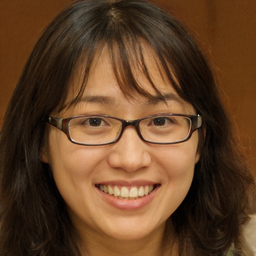

In [ ]:
id = 1226
print(f"Label associated to the 30-th sample: {float(df.loc[df['id'] == id]['glasses'])}.\nHowever, the 30-th image is clearly a person wearing glasses.\n")

from PIL import Image
with Image.open("faces-spring-2020/faces-spring-2020/face-" + str(id) + ".png") as img:
  display(img.resize((256, 256), Image.ANTIALIAS))

Label associated to the 31-th sample: 1.0.
However, the 31-th image is clearly a person with no glasses.



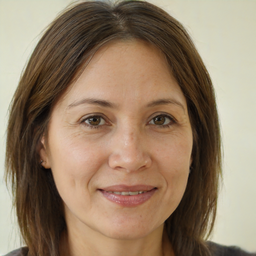

In [ ]:
id = 31
print(f"Label associated to the 31-th sample: {float(df.loc[df['id'] == id]['glasses'])}.\nHowever, the 31-th image is clearly a person with no glasses.\n")

with Image.open("faces-spring-2020/faces-spring-2020/face-" + str(id) + ".png") as img:
  display(img.resize((256, 256), Image.ANTIALIAS))

While correcting them, we also noticed some images in which stating if the person had glasses or not was hard: this happens because the subjects are created by a Generative Adversarial Neural Network (they are not real people), so there can be some errors.

Examples of images to which assigning a label could be misleading:



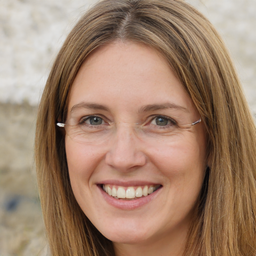

In [ ]:
print("Examples of images to which assigning a label could be misleading:\n")

with Image.open("faces-spring-2020/faces-spring-2020/face-428.png") as img:
  display(img.resize((256, 256), Image.ANTIALIAS))

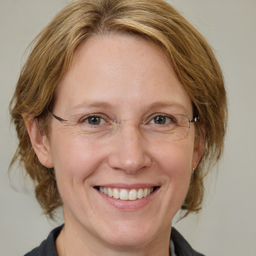

In [ ]:
with Image.open("faces-spring-2020/faces-spring-2020/face-549.png") as img:
  display(img.resize((256, 256), Image.ANTIALIAS))

In the GitHub repository of the project we provide a `.csv` file with all the correct labels associated with the `id` of the images (which are taken by the paths, since every image has a path with a unique number). We download it and replace the old labels column in the dataset, which is called `glasses`. Next, we drop samples with an undefined label.

In [ ]:
correct_labels_path = "https://raw.githubusercontent.com/flaviofuria/GlassesOrNoGlasses/main/labels.csv"
df["glasses"] = pd.read_csv(correct_labels_path)["label"] 

In [ ]:
if df.isnull().values.any():
    print(f"{df.isnull().values.ravel().sum()} row(s) with undefined labels in the set have been found and will be removed.\n")    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
df

37 row(s) with undefined labels in the set have been found and will be removed.



,id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,...,v474,v475,v476,v477,v478,v479,v480,v481,v482,v483,v484,v485,v486,v487,v488,v489,v490,v491,v492,v493,v494,v495,v496,v497,v498,v499,v500,v501,v502,v503,v504,v505,v506,v507,v508,v509,v510,v511,v512,glasses
0,1,0.37797,-0.94808,0.01346,0.17893,0.37795,0.63571,0.13943,-0.25607,-0.39341,1.08947,-1.36048,-1.31529,0.36119,-0.62857,-1.65290,1.47167,-0.88741,-0.25942,-0.34414,-0.38914,0.38425,-0.50553,-0.09451,0.30568,-1.07570,-0.65924,1.10918,1.22234,-0.12479,0.50198,-0.63932,0.61505,1.16747,0.36921,-0.44398,0.46192,-0.83207,-0.74952,-0.40722,...,0.54072,-0.71995,1.11262,-0.11429,0.85618,0.17233,-1.06815,0.04569,-0.13031,2.07549,0.47934,0.69172,1.37139,0.45480,-0.96053,0.06319,0.09664,-0.34749,0.09889,-0.87606,0.82594,0.52841,0.84209,0.16771,0.59003,-0.22960,-0.04017,0.15554,-0.41569,0.68050,-0.03494,1.32443,-0.94570,0.02055,-1.23908,0.43507,1.08635,1.69027,0.61609,0.0
1,2,0.07609,-0.09774,0.39666,-0.39026,0.10606,0.52774,0.07105,0.33720,0.69917,-0.02842,-0.56431,0.42060,-0.47533,1.60025,-0.02106,-2.30193,-0.31614,-0.08050,0.85041,-0.10574,-0.33177,-1.32102,-0.22244,-0.52076,0.40012,-0.41339,-0.15176,1.02155,-0.52834,0.66718,0.54844,0.18323,0.28764,-0.80084,-0.85040,0.45097,0.88317,-1.13375,-1.85301,...,-0.25966,-1.19259,-0.71514,-0.08903,-0.58853,-0.20697,-0.77025,-1.21129,-0.67575,0.32509,-0.35147,-0.33581,-0.31505,-1.66721,0.40666,0.15053,-0.77809,0.35837,-1.10950,0.03764,-0.93728,-0.68952,-0.92334,-0.35401,-1.20552,1.10199,0.46268,0.85954,-0.48484,-0.54585,0.86624,-1.24953,-0.21511,-1.54146,1.04765,-1.24035,0.00866,-1.27640,-0.60496,1.0
2,3,1.19391,-0.68707,-0.68422,-0.36378,-0.60847,-0.40118,1.45432,0.00592,1.68940,-0.98205,0.67435,-1.27604,-1.37050,-0.91682,0.23617,0.53676,-0.26815,-0.66989,0.46076,-0.04117,1.34078,0.46545,-0.25943,-0.22918,-0.49346,-0.53558,0.69776,1.15477,0.01293,-0.86763,-0.08987,0.54660,0.09142,-0.21663,-0.28233,0.15426,-1.02164,-0.24342,-0.18844,...,0.91472,-0.29778,0.45507,0.03296,-0.79752,1.19759,-0.45417,0.15993,0.39516,-0.87621,0.05737,-0.99432,1.19910,0.78989,-0.13908,0.12384,0.38121,0.05699,-0.89445,-0.67448,-0.07669,-1.50409,0.07962,0.95116,0.72782,-0.88516,0.40735,0.10415,0.31639,-0.34801,-0.35893,0.02330,0.31548,-0.34923,-0.41772,-0.58175,-0.60177,0.43555,0.41982,1.0
3,4,1.34949,-0.31498,-1.30248,0.50278,1.66292,-1.06094,-0.70835,-0.24237,-0.15509,-0.04532,0.97349,-0.21032,-0.71143,0.59725,-0.51849,0.00126,1.22219,0.57160,0.41212,0.90077,-0.80797,-1.20564,1.40774,0.49080,-1.05429,0.26300,-0.03849,-0.66792,-0.29260,0.47713,0.44967,0.44411,-0.13465,-0.20365,0.52841,-0.47348,0.39295,0.67695,0.40861,...,0.65551,-0.17916,0.55700,1.84589,0.70722,-0.55871,-1.18265,0.82509,-0.50715,0.71948,-1.08462,-0.05607,0.86918,-0.11338,-0.73700,-0.12130,0.81417,-0.61391,-0.90671,1.09301,0.37716,1.06373,-0.62199,-0.21279,-0.43245,-0.28904,-0.25435,-0.20458,-0.00398,1.18449,0.23942,0.20774,0.81792,-0.74814,-0.62521,0.01689,0.83997,-0.46986,0.06755,0.0
4,5,-0.03512,-0.34196,0.14230,1.50513,-0.14364,0.49429,0.07823,-0.04356,0.42009,-0.88828,0.13601,0.26917,0.11973,0.04378,1.06879,0.10060,-0.83331,-0.64776,0.26461,0.65249,-0.41807,0.65920,0.11838,-0.00525,-0.74657,-0.97743,-0.71398,-0.08356,-0.82942,0.60474,0.12790,-0.41187,-2.18319,0.27367,0.54507,0.26555,0.67382,-0.24832,0.43397,...,0.90449,-0.51652,-0.11353,1.59131,-0.15053,-0.03551,0.02906,0.16957,0.62629,0.71465,-0.77525,0.46366,0.03279,-0.17744,0.32256,0.16237,-0.52918,-1.07961,0.55594,0.07770,0.08003,0.86164,0.24552,-0.17842,0.57825,0.01275,-1.05442,-0.61130,0.72826,-1.61306,-1.78407,0.07465,1.50182,-0.41289,-0.55908,-0.29702,0.83641,0.59756,-0.20298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

<h1>Classes balancing</h1>

Now we look at the balance between the two classes, in order to decide if we should go for some `under/oversampling`.<br>Fortunately, the dataset is pretty well balanced, so we don't need to apply any sort of rebalancing.

2770 Glasses     ==>  ratio: 0.558
2193 No Glasses  ==>  ratio: 0.442


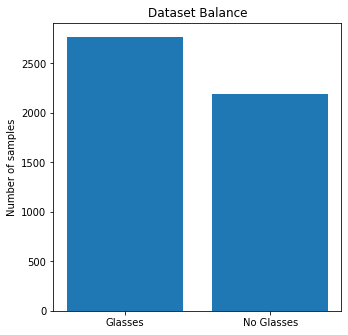

In [ ]:
ones, zeros = df["glasses"].value_counts()
print(f"{ones} Glasses     ==>  ratio: {round(ones/(ones+zeros), 3)}")
print(f"{zeros} No Glasses  ==>  ratio: {round(zeros/(ones+zeros), 3)}")
x_labels, x_values = ["Glasses", "No Glasses"], [ones, zeros]

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel("Number of samples")
ax.set_yticks(np.arange(0, df.shape[0], 500))
ax.bar(x_labels, x_values)
plt.title("Dataset Balance")
plt.show()

<h1>Data Visualization: PCA and t-SNE</h1>

Next we apply `dimensionality reduction`, a tool to map a high-dimensional space into a low-dimensional space, hopefully extracting the meaningful properties of the original data, and, at the same time, overlooking the less importat ones. We decide to reduce dimensionality only for visualization (thus we will reduce the dimensions from 512 to 2), using two techniques:
<ul>
  <li> Principal Component Analysis, a linear transformation that aims to map dissimilar points into distant low-dimensional representation.</li>
  <li> t-Distributed Stochastic Neighbor Embedding, that is non-linear and, in addition, tries to keep similar points closer in the low-dimensional representation. Being non-linear, it is harder to compute and, thus, often leads to better results.</li>
</ul>

N.B.: We apply PCA and t-SNE on the standardized dataset, in order to transform all the data to the same scale. We will talk about standardization soon.

In [ ]:
n_components = 2      # we only want to visualize data in a lower dimensional space, so we keep two dimensions

X = df.iloc[:, 1:-1]
Y = np.array(df["glasses"])

In [ ]:
from matplotlib.colors import ListedColormap

def dim_reduction_plot(first_dimension:np.array, second_dimension:np.array, labels:np.array, title=str):
  fig = plt.figure(figsize=(8, 8))
  plt.title(title)
  colors = ListedColormap(["blue", "orange"])
  scatter = plt.scatter(first_dimension, second_dimension, alpha=0.7, marker=".", c=labels, cmap=colors)
  plt.legend(handles=scatter.legend_elements()[0], labels=["Glasses", "No Glasses"])
  plt.show()

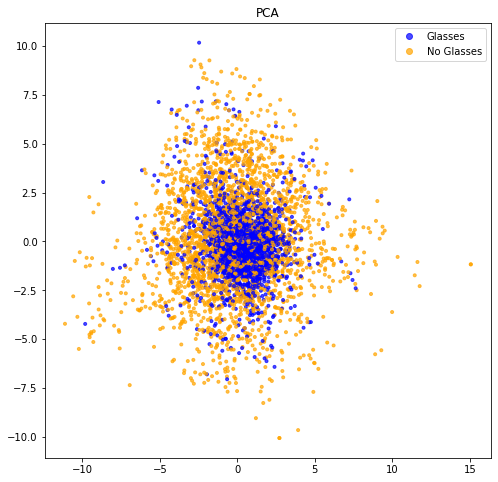

In [ ]:
from sklearn.preprocessing import StandardScaler
scaled_X = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca_X = PCA(n_components=n_components, random_state=seed).fit_transform(scaled_X)

if n_components == 2:
  dim_reduction_plot(pca_X[:, 0], pca_X[:, 1], Y, "PCA")

PCA does show something: we can see that samples corresponding to people with glasses are grouped around the center. Maybe t-SNE will tell us even more.

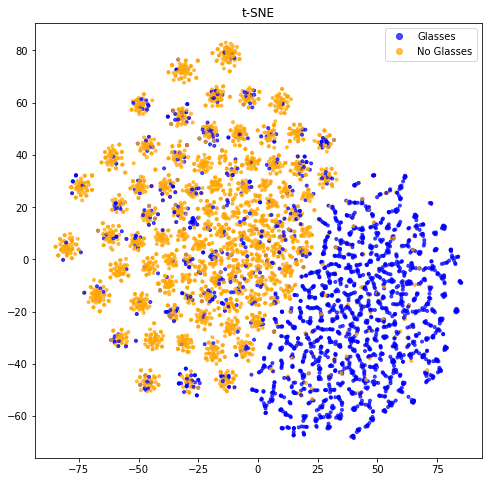

In [ ]:
from sklearn.manifold import TSNE
tsne_X = TSNE(n_components=n_components, perplexity=30, init="pca", random_state=seed, method="barnes_hut", n_jobs=-1).fit_transform(scaled_X)

if n_components == 2:
  dim_reduction_plot(tsne_X[:, 0], tsne_X[:, 1], Y, "t-SNE")

t-SNE (thus, non-linearity) works definitely better: there is a clear line that separates the majority of positive and negative samples. When the dimensionality is high, it is good practice to pre-apply PCA to the dataset before applying t-SNE. Let's try and see what we get.

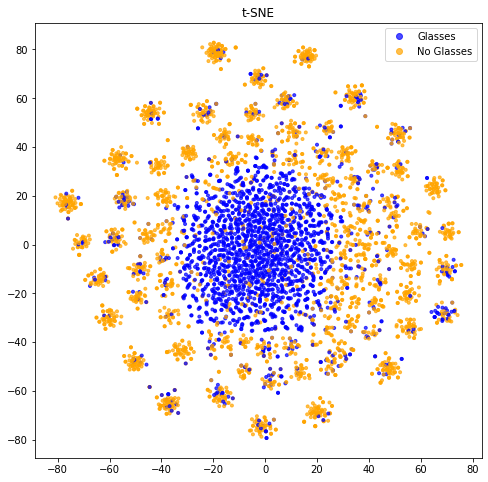

In [ ]:
from sklearn.manifold import TSNE
tsne_X = TSNE(n_components=n_components, perplexity=30, init="pca", random_state=seed, method="barnes_hut", n_jobs=-1).fit_transform(PCA(n_components=30, random_state=seed).fit_transform(scaled_X))

if n_components == 2:
  dim_reduction_plot(tsne_X[:, 0], tsne_X[:, 1], Y, "t-SNE")

The majority of positive samples are again clustered around the center like we had on PCA, while for the negative samples we can see dozens of little clustered (and in some of them there are also positive samples). Both the t-SNE representations, however, convinced us that there is a correlation between data and labels and we hope that our neural networks will be able to capture it.

<h1>Train/Test split</h1>

We do now a `train/test split` with a ratio of `0.8/0.2`. For the validation set, we will let Keras do the job, automatically creating a `validation set`, splitting the training set with a ratio of `0.8/0.2` again.

In [ ]:
X = df.iloc[:, 1:-1]
Y = np.array(df["glasses"])

test_size = 0.2

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

print(f"Training set:   {X_train.shape}")
print(f"Test set:        {X_test.shape}")

Training set:   (3970, 512)
Test set:        (993, 512)


<h1>Standardization</h1>

At this point we want to `standardize` the data, i.e. apply a transformation that makes all the features to be `centered around 0` and have a `variance of 1`.  In order to let the test set to be as *untouched* as we can, we will fit the `Sklearn StandardScaler` on the training set alone and then apply the trasformation on both the datasets.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler().fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform (X_test)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.DataFrame(pd.DataFrame(X_train).describe().transpose(), columns=["mean","std"]).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
mean,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,...,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,...,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001


In [ ]:
pd.DataFrame(pd.DataFrame(X_test).describe().transpose(), columns=["mean","std"]).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
mean,0.0303,-0.0219,0.0411,-0.0534,-0.0140,0.0140,-0.0111,-0.0626,0.0510,-0.0276,-0.0529,-0.0536,0.0077,-0.0603,0.0917,0.0315,0.0439,0.0143,-0.0061,0.0425,-0.0169,-0.0119,-0.0343,-0.0926,-0.0236,0.0795,0.0630,0.0036,0.0314,0.0422,0.0466,0.0179,0.0186,-0.0021,-0.0169,0.0754,0.0028,0.0336,-0.0357,-0.0305,...,-0.0077,-0.0246,-0.0085,-0.0938,0.0039,0.0366,-0.0546,-0.0244,0.0103,0.0169,0.0138,-0.0515,-0.0205,-0.0430,0.0133,-0.0262,0.0055,-0.0329,0.0767,0.0113,-0.0403,0.0057,0.0744,0.0003,0.0205,-0.0299,0.0554,-0.0454,0.0533,0.0099,-0.0746,-0.0432,-0.0231,-0.0639,-0.0482,-0.0287,-0.0057,0.0346,-0.0331,-0.0004
std,1.0548,0.9936,0.9938,0.9924,0.9906,0.9775,0.9831,0.9756,0.9832,0.9934,0.9963,0.9469,0.9935,1.0248,0.9771,1.0273,0.9736,1.0018,0.9750,0.9895,1.0643,1.0102,0.9900,0.9720,1.0647,1.0199,0.9467,1.0105,0.9730,0.9796,0.9896,0.9757,1.0170,0.9961,0.9942,0.9757,0.9618,0.9836,0.9632,1.0133,...,0.9770,0.9853,0.9948,0.9769,1.0055,1.0008,0.9679,1.0243,1.0211,0.9751,1.0087,1.0185,0.9773,0.9927,1.0103,0.9713,0.9868,1.0117,1.0104,0.9587,0.9880,1.0247,1.0617,1.0001,0.9677,1.0177,1.0073,1.0093,1.0379,0.9664,1.0135,0.9653,1.0256,0.9948,1.0030,0.9860,1.0290,0.9406,1.0118,1.0070


The mean and std are now 0 and 1 respectively for all the features of the training set while, for the test set, they are not. However, they are not so far either.

**<h1>Multi-Layer Perceptrons</h1>**

We will use a simple function that given a `list of layers`, an `optimizer`, a `loss function` and a `list of metrics` return a `Keras model`. Next, we provide some simple functions that simply plot and print model results.

In [ ]:
from tensorflow.keras.models import Sequential
def build_model(layers_list:list, optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) -> Sequential:
    model = Sequential()    
    for l in layers_list:
        model.add(l)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)  
    return model

In [ ]:
def plot_results(metrics:(), metric_name:str, path=None):
  plt.figure()
  plt.plot(metrics[0])
  plt.plot(metrics[1])
  if path:
    plt.title(str(path) + " " + metric_name)
  else:
    plt.title("Model "+metric_name)
  plt.ylabel(metric_name)
  plt.xlabel("epoch")
  plt.legend(["train", "val"], loc="upper left")
  if path:
    plt.savefig("plots/"+str(path).lower()+"_"+str(metric_name)+".png")
  else:
    plt.show()


def plot_and_print(hist, test_loss, test_accuracy, index, path=None):
  print(f"The following scores come from the {index+1}-th epoch, the best one according to validation loss\n")
  print(f"Training Accuracy:    {round(hist.history['accuracy'][index], 4)}")
  print(f"Validation Accuracy:  {round(hist.history['val_accuracy'][index], 4)}")
  print(f"Test Accuracy:        {round(test_accuracy, 4)}\n")

  print(f"Training Loss:        {round(hist.history['loss'][index], 4)}")
  print(f"Validation Loss:      {round(hist.history['val_loss'][index], 4)}")
  print(f"Test Loss:            {round(test_loss, 4)}\n\n")

  plot_results((hist.history["accuracy"], hist.history["val_accuracy"]), "accuracy", path)
  plot_results((hist.history["loss"], hist.history["val_loss"]), "loss", path)


from sklearn.metrics import roc_curve, auc
def auroc_plot(test, predictions, path=None):
  fpr, tpr, thresholds = roc_curve(test, predictions)
  AUC = auc(fpr, tpr)

  plt.figure()
  if path:
    plt.title(path + " ROC curve")
  else:
    plt.tilte("ROC curve")
  plt.plot(fpr, tpr, label = "AUC = %0.2f" % AUC)
  plt.legend(loc="lower right")
  plt.plot([0, 1], [0, 1],"r--")
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel("True Positive Rate")
  plt.xlabel("False Positive Rate")
  if path:
    plt.savefig("plots/"+path.lower()+"_roc_curve.png")
  else:
    plt.show()

<h1>First try</h1>

We create a folder to save the weights obtained in the epoch with the lowest `validation loss`: in this way once the training phase has ended we can revert to the best combination of weights according to validation loss and use this one to evaluate the model; we will also rely on the results obtained in that exact epoch. This will happen for every model from now on.

In [ ]:
!mkdir model_weights
!mkdir plots

We are facing a binary classification problem. Thus, we use `sigmoid` as function for our output neuron and `binary crossentropy` as loss function. We try a simple model with just one hidden layer of 16 `neurons` and one of 8 `neurons`, both with `relu` activation functions, a `batch size` of 128 and 50 `epochs`. Probably the model will stop before going through all of them, because we also opt for an `early stopping` if the `validation loss` stops to decrease. We use `Adam` with a `learning rate` of 0.001 (the default one) as the `optimizer`. As already said, we will use the 20% of the training set as validation set.<br>

In [ ]:
epochs = 50
batch_size = 128

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_loss", patience=5)
checkpoint = ModelCheckpoint(filepath="model_weights/first_try.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

num_features = X_train.shape[1]
val_split = 0.2

In [ ]:
from tensorflow.keras.layers import Dense
layers_list = [Dense(16, activation="relu", input_shape=(num_features,)),
               Dense(8, activation="relu"),
               Dense(1, activation="sigmoid")]

first_model = build_model(layers_list)
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,353
Trainable params: 8,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
first_history = first_model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/50
25/25 [==============================] - 1s 12ms/step - loss: 0.6399 - accuracy: 0.6130 - val_loss: 0.5443 - val_accuracy: 0.7406
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4661 - accuracy: 0.7950 - val_loss: 0.4454 - val_accuracy: 0.8136
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.3698 - accuracy: 0.8700 - val_loss: 0.3761 - val_accuracy: 0.8438
Epoch 4/50
25/25 [==============================] - 0s 5ms/step - loss: 0.3026 - accuracy: 0.8923 - val_loss: 0.3370 - val_accuracy: 0.8715
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.2588 - accuracy: 0.9037 - val_loss: 0.3146 - val_accuracy: 0.8753
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.2291 - accuracy: 0.9150 - val_loss: 0.3061 - val_accuracy: 0.8804
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.2050 - accuracy: 0.9229 - val_loss: 0.2986 - val_accuracy: 0.8829
Epoch 8/50
25/25 [=

The following scores come from the 9-th epoch, the best one according to validation loss

Training Accuracy:    0.9373
Validation Accuracy:  0.8866
Test Accuracy:        0.8691

Training Loss:        0.1688
Validation Loss:      0.298
Test Loss:            0.3228




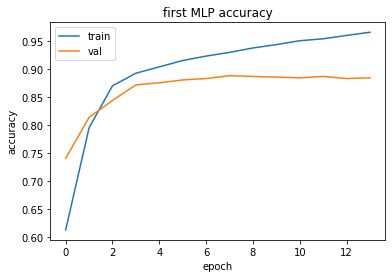

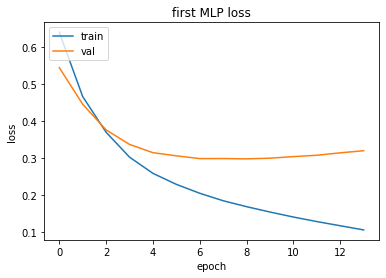

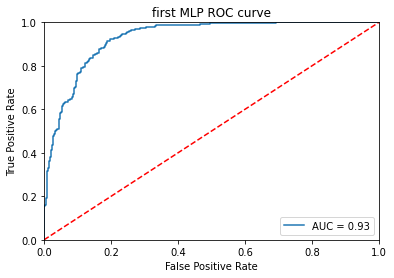

In [ ]:
first_model.load_weights("model_weights/first_try.hdf5")
first_test_loss, first_test_accuracy = first_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(first_history.history["val_loss"])
plot_and_print(first_history, first_test_loss, first_test_accuracy, best_epoch_index, path="first MLP")

auroc_plot(Y_test, first_model.predict(X_test, batch_size=batch_size), "first MLP")

The accuracy and loss plots clearly show us that our predictor starts `overfitting` after just few epochs. In fact, after ten epochs the validation loss starts increasing, so the training stops. The number of parameters is way too high with respect to the number of samples, so we can try to apply `dropout`, hoping that "switching off" some neurons (thus, reducing parameters), will bring overfitting down.

<h1>Second try (with Dropout)</h1>

As we have just said, adding units or layers would make the network overfit even more; thus, we try a model with the same architecture of the last one, but we give each neuron between the first and the second layer a probability of `0.4` to be switched off to be omitted during training.

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10)     # 200 epochs are probably be too much, so we stop when validation loss stops decreasing
checkpoint = ModelCheckpoint(filepath="model_weights/second_try.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

from tensorflow.keras.layers import Dropout
layers_list = [Dense(16, activation="relu", input_shape=(num_features,)),
               Dropout(0.4, seed=seed),
               Dense(8, activation="relu"),
               Dense(1, activation="sigmoid")]

second_model = build_model(layers_list)
second_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                8208      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,353
Trainable params: 8,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
second_history = second_model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/50
25/25 [==============================] - 1s 11ms/step - loss: 0.6792 - accuracy: 0.5967 - val_loss: 0.5984 - val_accuracy: 0.7040
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5703 - accuracy: 0.7034 - val_loss: 0.5237 - val_accuracy: 0.7859
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4894 - accuracy: 0.7758 - val_loss: 0.4428 - val_accuracy: 0.8501
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4179 - accuracy: 0.8303 - val_loss: 0.3787 - val_accuracy: 0.8602
Epoch 5/50
25/25 [==============================] - 0s 5ms/step - loss: 0.3639 - accuracy: 0.8460 - val_loss: 0.3372 - val_accuracy: 0.8741
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.3400 - accuracy: 0.8643 - val_loss: 0.3176 - val_accuracy: 0.8741
Epoch 7/50
25/25 [==============================] - 0s 5ms/step - loss: 0.3124 - accuracy: 0.8690 - val_loss: 0.3047 - val_accuracy: 0.8829
Epoch 8/50
25/25 [=

The following scores come from the 14-th epoch, the best one according to validation loss

Training Accuracy:    0.9055
Validation Accuracy:  0.8892
Test Accuracy:        0.8781

Training Loss:        0.2168
Validation Loss:      0.2843
Test Loss:            0.3158




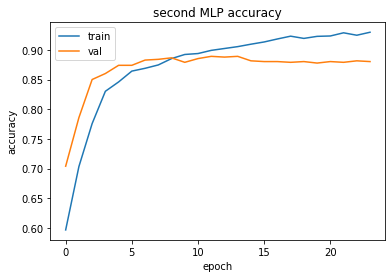

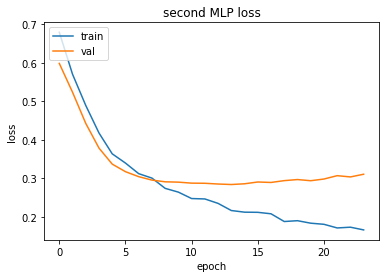

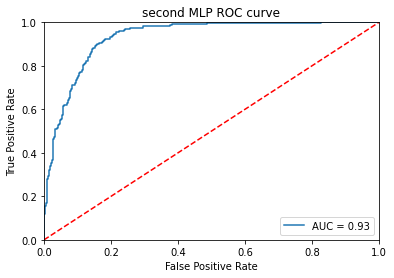

In [ ]:
second_model.load_weights("model_weights/second_try.hdf5")
second_test_loss, second_test_accuracy = second_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(second_history.history["val_loss"])
plot_and_print(second_history, second_test_loss, second_test_accuracy, best_epoch_index, path="second MLP")

auroc_plot(Y_test, second_model.predict(X_test, batch_size=batch_size), "second MLP")

As expected, overfitting is still here, but at least we have lowered it in some way (or, at least, it appears a bit later). As a result, the scores for the training set are slightly worse but those for the validation/test set are slightly better/not worse. Can we do better? 

<h1>Third try (with regularizers and lower learning rate)</h1>

We add some units with some more dropout probability and use two regularization parameters, `l1` and `l2`, which both penalize the weights of the neurons and, together with dropout, fight against overfitting. Other than that, we lower the initial (it will be automatically adapted during the training, according to the Adam implementation) default learning rate for the Adam optimizer from `1e-3` to `1e-4`: this means that the overall training process will be slower but hopefully the gradient descent will converge to some point of global minimum.

In [ ]:
epochs = 200                                                        # we increase the number of epochs because a lower learning rate slows the training process down
batch_size = 128

early_stopping = EarlyStopping(monitor="val_loss", patience=10)     # 200 epochs are probably be too much, so we stop when validation loss stops decreasing
checkpoint = ModelCheckpoint(filepath="model_weights/third_try.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

from tensorflow.keras.optimizers import Adam
optimizer = Adam(1e-4)

from tensorflow.keras import regularizers
layers_list = [Dense(16, activation="relu", input_shape=(num_features,)),
               Dropout(0.4, seed=seed),
               Dense(16, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=.00001, l2=.00001)),
               Dropout(0.3, seed=seed),
               Dense(1, activation="sigmoid")]

third_model = build_model(layers_list, optimizer=optimizer)
third_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                8208      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,497
Trainable params: 8,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
third_history = third_model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/200
25/25 [==============================] - 1s 11ms/step - loss: 0.8569 - accuracy: 0.5069 - val_loss: 0.7209 - val_accuracy: 0.5416
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 0.8308 - accuracy: 0.5116 - val_loss: 0.7018 - val_accuracy: 0.5542
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.8100 - accuracy: 0.5453 - val_loss: 0.6845 - val_accuracy: 0.5668
Epoch 4/200
25/25 [==============================] - 0s 5ms/step - loss: 0.7662 - accuracy: 0.5589 - val_loss: 0.6693 - val_accuracy: 0.5907
Epoch 5/200
25/25 [==============================] - 0s 5ms/step - loss: 0.7341 - accuracy: 0.5765 - val_loss: 0.6558 - val_accuracy: 0.6058
Epoch 6/200
25/25 [==============================] - 0s 5ms/step - loss: 0.7461 - accuracy: 0.5721 - val_loss: 0.6427 - val_accuracy: 0.6234
Epoch 7/200
25/25 [==============================] - 0s 5ms/step - loss: 0.7276 - accuracy: 0.5822 - val_loss: 0.6304 - val_accuracy: 0.6398
Epoch 8/200


The following scores come from the 113-th epoch, the best one according to validation loss

Training Accuracy:    0.9011
Validation Accuracy:  0.8866
Test Accuracy:        0.8781

Training Loss:        0.2571
Validation Loss:      0.2873
Test Loss:            0.3071




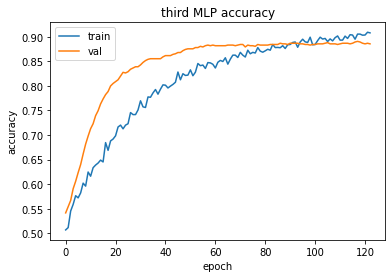

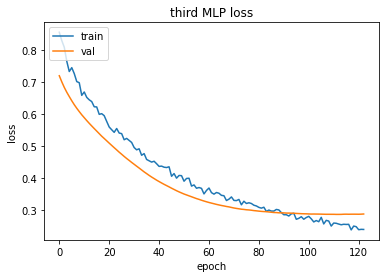

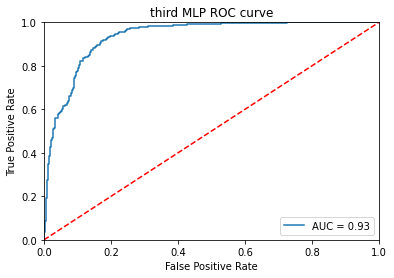

In [ ]:
third_model.load_weights("model_weights/third_try.hdf5")
third_test_loss, third_test_accuracy = third_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(third_history.history["val_loss"])
plot_and_print(third_history, third_test_loss, third_test_accuracy, best_epoch_index, path="third MLP")

predictions = third_model.predict(X_test, batch_size=batch_size)
auroc_plot(Y_test, predictions, "third MLP")

Overfitting has almost disappeared, but the results did not improve. Maybe there is no much more that we can do, but we can do one more thing.

<h1>Bayesian Optimization</h1>

There could be a better choice of architecture and hyperparameters: we will found out if it's true thanks to `Bayesian Optimization`, a tool that given an hyperparameter search space, finds the best combination of them in order to minimize the `validation loss`.Since it easy quite computationally expensive, just lower the values of `max_trials` and `executions_per_trial` to get a faster execution. We use the implementation provided in the [keras-tuner](https://github.com/keras-team/keras-tuner) framework.

In [ ]:
!pip install -q keras_tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


We first define a function that will build our model, giving a range of hyperparameters that will form the search space for the optimization tool.

In [ ]:
def bayesian_opt_model(hp):
  model = Sequential()
  model.add(Dense(units=hp.Int("units_0", 8, 256, 16), activation=hp.Choice("activation_0", ["relu", "sigmoid", "tanh"]), input_shape=(num_features,)))
  if hp.Boolean(name='dropout_0'):
    model.add(Dropout(rate=hp.Choice("rate_0", [0e-1, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1]), seed=seed))
  for i in range(hp.Int("num_layers", 1, 6)):
    model.add(Dense(units=hp.Int("units_"+str(i), 8, 256, 16),
                    kernel_regularizer=regularizers.l1_l2(l1=hp.Choice("l1_"+str(i), [0e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]), l2=hp.Choice("l2_"+str(i), [0e-1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])),
                    activation=hp.Choice("activation_"+str(i), ["relu", "sigmoid", "tanh"])))
    if hp.Boolean(name='dropout_'+str(i)):
      model.add(Dropout(rate=hp.Choice("rate_"+str(i), [0e-1, 1e-1, 2e-1, 3e-1, 4e-1, 5e-1, 6e-1, 7e-1, 8e-1, 9e-1]), seed=seed))
  model.add(Dense(1, activation="sigmoid"))    
  model.compile(optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]),
                               beta_1=hp.Choice("beta_1", [6e-1, 7e-1, 8e-1, 9e-1]),
                               beta_2=hp.Choice("beta_2", [9.85e-1, 9.90e-1, 9.95e-1, 9.99e-1]), amsgrad=hp.Boolean("amsgrad")), loss="binary_crossentropy", metrics=["accuracy"])
  return model

We create the model and search for the best hyperparameters combination.

In [ ]:
max_trials = 10
executions_per_trial = 5

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

from keras_tuner import BayesianOptimization
bayesian_opt = BayesianOptimization(bayesian_opt_model, objective="val_loss", max_trials=max_trials, executions_per_trial=executions_per_trial, seed=seed, project_name="glasses")
bayesian_opt.search(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split, shuffle=True, verbose=1, callbacks=[early_stopping])

Trial 10 Complete [00h 00m 15s]
val_loss: 0.3233082592487335

Best val_loss So Far: 0.29969332218170164
Total elapsed time: 00h 09m 47s
INFO:tensorflow:Oracle triggered exit


We can easily get the best model found by this algorithm and train it as every other model, remembering that, as always, we are mostly interested in the performance on the test set. 

In [ ]:
best_hyperparameters = bayesian_opt.get_best_hyperparameters(num_trials=1)[0]
bayesian_model = bayesian_opt.hypermodel.build(best_hyperparameters)

In [ ]:
bayesian_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 72)                36936     
                                                                 
 dense_4 (Dense)             (None, 72)                5256      
                                                                 
 dense_5 (Dense)             (None, 1)                 73        
                                                                 
Total params: 42,265
Trainable params: 42,265
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=10)
checkpoint = ModelCheckpoint(filepath="model_weights/bayesian.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

bayesian_history = bayesian_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=val_split, shuffle=True, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/200
25/25 [==============================] - 1s 13ms/step - loss: 0.4035 - accuracy: 0.8218 - val_loss: 0.3106 - val_accuracy: 0.8841
Epoch 2/200
25/25 [==============================] - 0s 6ms/step - loss: 0.2033 - accuracy: 0.9232 - val_loss: 0.3164 - val_accuracy: 0.8766
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 0.1305 - accuracy: 0.9462 - val_loss: 0.4104 - val_accuracy: 0.8804
Epoch 4/200
25/25 [==============================] - 0s 6ms/step - loss: 0.1063 - accuracy: 0.9616 - val_loss: 0.4397 - val_accuracy: 0.8703
Epoch 5/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0740 - accuracy: 0.9742 - val_loss: 0.4988 - val_accuracy: 0.8778
Epoch 6/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0508 - accuracy: 0.9830 - val_loss: 0.5263 - val_accuracy: 0.8841
Epoch 7/200
25/25 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.9776 - val_loss: 0.4993 - val_accuracy: 0.8829
Epoch 8/200


The following scores come from the 1-th epoch, the best one according to validation loss

Training Accuracy:    0.8218
Validation Accuracy:  0.8841
Test Accuracy:        0.864

Training Loss:        0.4035
Validation Loss:      0.3106
Test Loss:            0.3355




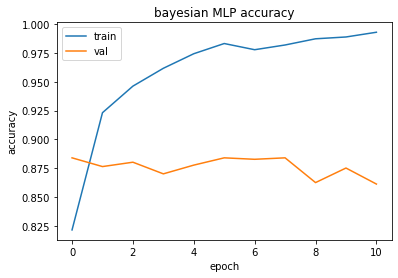

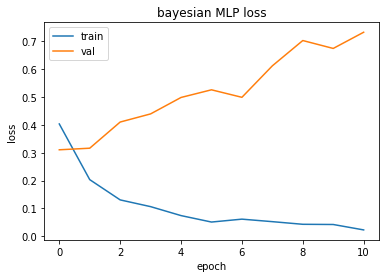

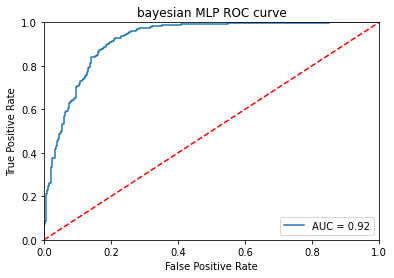

In [ ]:
bayesian_model.load_weights("model_weights/bayesian.hdf5")
bayesian_test_loss, bayesian_test_accuracy = bayesian_model.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(bayesian_history.history["val_loss"])
plot_and_print(bayesian_history, bayesian_test_loss, bayesian_test_accuracy, best_epoch_index, path="bayesian MLP")

auroc_plot(Y_test, bayesian_model.predict(X_test, batch_size=batch_size), "bayesian MLP")

The second and third model were slightly better, especially on the test set. We go back to the third model and apply K-fold cross-validation.

<h1>Applying K-Fold Cross-Validation (on the third model)</h1>

`K-Fold Cross-Validation` is a technique that consists in dividing the training set in `K` subsets/folds and then train the model K times: each time we use `K-1` folds to train the model and `1` to test it (each time one different fold is used this way). In the end we take the average of all the produced scores in order to have an estimate of the performance of our model when it receives different combinations of train/test sets (seen/unseen data).<br>
In order to make each step as unique as we can, we will create the folds starting from the original dataset and then scale the datasets as we have done originally (fitting the scaler on the training set and then applying it on both of them).

---
We use a simple function to plot the scores of the various folds.

In [ ]:
def kfold_plots(folds_results:dict, path=None):
  kfold_accuracy = []
  kfold_loss = []

  for key, value in folds_results.items():
    if "accuracy" in key:
      kfold_accuracy.append((np.mean(value), np.std(value)))
    else:
      kfold_loss.append((np.mean(value), np.std(value)))

  fig, ax = plt.subplots()
  fig.set_size_inches(5, 5)
  if path:
    ax.set_title(str(path)+" K-Fold Accuracy")
  else:
    ax.set_title("K-Fold Accuracy")
  ax.set_xlim(0.80, 1.05)
  ax.barh(y=["train", "val", "test"], width=[mean[0] for mean in kfold_accuracy], xerr=[std[1] for std in kfold_accuracy])
  if path:
    plt.savefig("plots/"+str(path).lower()+"_kfold_accuracy.png")

  fig, ax = plt.subplots()
  fig.set_size_inches(5, 5)
  if path:
    ax.set_title(str(path)+" K-Fold Loss")
  else:
    ax.set_title("K-Fold Loss")
  ax.set_xlim(0.00, 0.35)
  ax.barh(y=["train", "val", "test"], width=[mean[0] for mean in kfold_loss], xerr=[std[1] for std in kfold_loss])
  if path:
    plt.savefig("plots/"+str(path).lower()+"_kfold_loss.png")

In [ ]:
k = 10
verbose = 0
folds_results = {"accuracy":[], "val_accuracy":[], "test_accuracy":[], "loss":[], "val_loss":[], "test_loss":[]}

X = np.array(X)

j = 0
from sklearn.model_selection import KFold
k_fold_mlp = KFold(n_splits=k, shuffle=True, random_state=seed)
for train_fold, test_fold in k_fold_mlp.split(np.array(X)):

  X_train, X_test = X[train_fold], X[test_fold]
  Y_train, Y_test = Y[train_fold], Y[test_fold]

  scaler = StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform (X_test)

  tf.keras.backend.clear_session()
  model = build_model(layers_list, optimizer=Adam(1e-4))

  early_stopping = EarlyStopping(monitor="val_loss", patience=10)
  checkpoint = ModelCheckpoint(filepath="model_weights/"+str(j)+"th_fold_numerical.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)
  history = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=verbose, callbacks=[early_stopping, checkpoint])   

  best_epoch_index = np.argmin(history.history["val_loss"])
  folds_results["accuracy"].append(history.history["accuracy"][best_epoch_index])
  folds_results["val_accuracy"].append(history.history["val_accuracy"][best_epoch_index])
  folds_results["loss"].append(history.history["loss"][best_epoch_index])
  folds_results["val_loss"].append(history.history["val_loss"][best_epoch_index])

  model.load_weights("model_weights/"+str(j)+"th_fold_numerical.hdf5")
  test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
  folds_results["test_accuracy"].append(test_accuracy)
  folds_results["test_loss"].append(test_loss)

  if verbose:
    print(f"\n\n{j+1}-th FOLD OUT OF {k}\n")
    plot_results((history.history["accuracy"], history.history["val_accuracy"]), "accuracy")
    plot_results((history.history["loss"], history.history["val_loss"]), "loss")
  
  j += 1

In [ ]:
print(f"Avg Training Accuracy:    {round(np.mean(folds_results['accuracy']), 4)}")
print(f"Avg Validation Accuracy:  {round(np.mean(folds_results['val_accuracy']), 4)}")
print(f"Avg Test Accuracy:        {round(np.mean(folds_results['test_accuracy']), 4)}")
print(f"\nAvg Training Loss:        {round(np.mean(folds_results['loss']), 4)}")
print(f"Avg Validation Loss:      {round(np.mean(folds_results['val_loss']), 4)}")
print(f"Avg Test Loss:            {round(np.mean(folds_results['test_loss']), 4)}\n\n")

Avg Training Accuracy:    0.885
Avg Validation Accuracy:  0.9081
Avg Test Accuracy:        0.9142

Avg Training Loss:        0.2937
Avg Validation Loss:      0.2203
Avg Test Loss:            0.2182




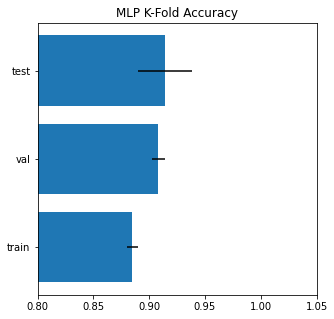

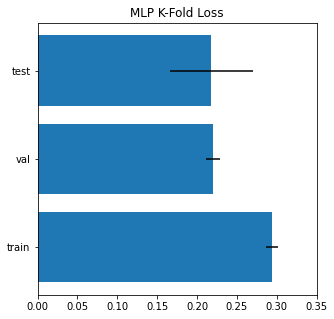

In [ ]:
kfold_plots(folds_results, path="MLP")

We are satisfied with the result, in the sense that they are reliable with respect to what we got when we simply trained the model without K-fold CV. However, we are not much satisfied with the overall scores: maybe there is no great room for improvements; thus, we move to images, with the idea that they will lead to definitely better results.

**<h1>Images</h1>**

As already said, this dataset is made up of `1024x1024x3` RGB images of (not real) people wearing or not wearing glasses.

Example of person wearing glasses.


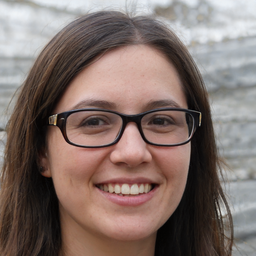

In [ ]:
print("Example of person wearing glasses.")
with Image.open("faces-spring-2020/faces-spring-2020/face-15.png") as img:
  display(img.resize((256, 256), Image.ANTIALIAS))

Example of person not wearing glasses.


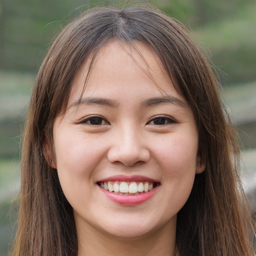

In [ ]:
print("Example of person not wearing glasses.")
with Image.open("faces-spring-2020/faces-spring-2020/face-13.png") as img:
  display(img.resize((256, 256), Image.ANTIALIAS))

<h1>Importing the data</h1>

The images have already been downloaded in the beginning of this notebook. We import them using `Pillow`, one of the most used Python libraries for images. For matter of space and time complexity, we fix the size of images to be` 128x128x1`, meaning that we have not only made them smaller but also converted them to `grayscale`: we think that this loss of information will not affect much the performance of our CNN and will make it noticeably lighter and faster. We turn every image to a `Numpy array` and use the same array of labels we used for numerical data, dropping samples with undefined labels, as we have already shown earlier.

In [ ]:
def import_image(path:str, width=128, height=128, choice="") -> np.ndarray:
  with Image.open(path) as img:
    if choice:
      img = img.convert(choice)
    img = img.resize((width, height), Image.ANTIALIAS)
  return np.array(img)


def display_image(path:str, width=256, heigth=256, choice="") -> np.ndarray:
  with Image.open(path) as img:
    if choice:
      img = img.convert(choice)
    display(img.resize((width, height), Image.ANTIALIAS))

In [ ]:
correct_labels_path = "https://raw.githubusercontent.com/flaviofuria/GlassesOrNoGlasses/main/labels.csv"
Y = np.array(pd.read_csv(correct_labels_path)["label"])
labeled = list(np.argwhere((Y==1.0)|(Y==0.0)).flatten())
Y = Y[labeled]

In [ ]:
choice = "L"    # "P" for palette, "L" for grayscale, "" for RGB
width, height = 128, 128
imgs_matrices = np.empty(shape=(len(labeled)), dtype=np.ndarray)

for i, id in enumerate(labeled):
  path = "faces-spring-2020/faces-spring-2020/face-" + str(id+1) + ".png"
  imgs_matrices[i] = import_image(path, width, height, choice)

X = np.array(imgs_matrices.tolist())
if choice:
  X = X.reshape((X.shape[0], X.shape[1], X.shape[2], 1))
X.shape

(4963, 128, 128, 1)

In order to have values ranging from 0 to 1, we `normalize` each pixel value of each sample, dividing it by `255`. 

In [ ]:
X = X / 255.0

**<h1>Convolutional Neural Network</h1>**
<h1>Train/Test split</h1>

As we did before, we proceed with a 0.8/0.2 train/test split.

In [ ]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

print(f"Training set:   {X_train.shape}")
print(f"Test set:        {X_test.shape}")

Training set:   (3970, 128, 128, 1)
Test set:        (993, 128, 128, 1)


<h1>Training the Model</h1>

We opt for a not so deep CNN with two convolutional layers with `kernels` of size `3x3` and `5x5`, respectively, each one followed by a max pooling layer with a `stride` of `2` and, after the flatten layer, two dense layers with 32 and 16 units respectively. The optimizer is Adam, with default parameters, while binary crossentropy is the loss function.

In [ ]:
shape = X.shape[1:]

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
layers_list = [Conv2D(kernel_size=3, filters=16, activation="relu", input_shape=shape),
               MaxPooling2D(strides=2),
               Conv2D(kernel_size=5, filters=32, activation="relu"),
               MaxPooling2D(strides=2),
               Flatten(),
               Dense(32, activation="relu"),
               Dense(16, activation="relu"),
               Dense(1, activation="sigmoid")]

In [ ]:
cnn = build_model(layers_list)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 26912)             0         
                                                                 
 dense (Dense)               (None, 32)               

We will probably need a smaller number of epochs to train our model: we set the number of epochs to 15, but we will stop if the validation loss starts increasing. As usual, we will save the weights of the best epoch, according to validation loss, and use them to evaluate the model.

In [ ]:
epochs = 15
batch_size = 64
val_split = 0.2

early_stopping = EarlyStopping(monitor="val_loss", patience=3)
checkpoint = ModelCheckpoint(filepath="model_weights/cnn_images.hdf5", monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True)

history = cnn.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/15
50/50 [==============================] - 50s 981ms/step - loss: 0.5490 - accuracy: 0.7314 - val_loss: 0.2311 - val_accuracy: 0.9358
Epoch 2/15
50/50 [==============================] - 49s 988ms/step - loss: 0.1230 - accuracy: 0.9616 - val_loss: 0.0803 - val_accuracy: 0.9861
Epoch 3/15
50/50 [==============================] - 49s 986ms/step - loss: 0.0488 - accuracy: 0.9865 - val_loss: 0.0497 - val_accuracy: 0.9937
Epoch 4/15
50/50 [==============================] - 49s 987ms/step - loss: 0.0322 - accuracy: 0.9909 - val_loss: 0.0357 - val_accuracy: 0.9849
Epoch 5/15
50/50 [==============================] - 49s 986ms/step - loss: 0.0225 - accuracy: 0.9934 - val_loss: 0.0164 - val_accuracy: 0.9987
Epoch 6/15
50/50 [==============================] - 53s 1s/step - loss: 0.0122 - accuracy: 0.9969 - val_loss: 0.0149 - val_accuracy: 0.9987
Epoch 7/15
50/50 [==============================] - 49s 990ms/step - loss: 0.0109 - accuracy: 0.9972 - val_loss: 0.0099 - val_accuracy: 0.9987
Ep

The following scores come from the 15-th epoch, the best one according to validation loss

Training Accuracy:    1.0
Validation Accuracy:  1.0
Test Accuracy:        0.996

Training Loss:        0.0005
Validation Loss:      0.0018
Test Loss:            0.0099




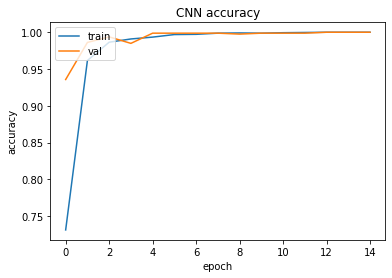

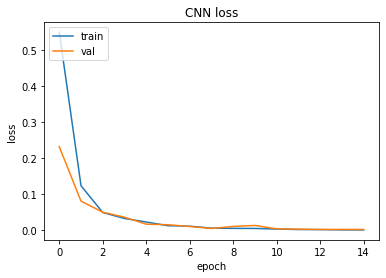

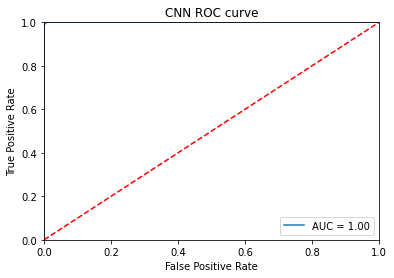

In [ ]:
cnn.load_weights("model_weights/cnn_images.hdf5")
test_loss, test_accuracy = cnn.evaluate(X_test, Y_test, batch_size, verbose=0)

best_epoch_index = np.argmin(history.history["val_loss"])
plot_and_print(history, test_loss, test_accuracy, best_epoch_index, "CNN")

predictions = cnn.predict(X_test, batch_size=batch_size)
auroc_plot(Y_test, predictions, "CNN")

The results are **way** better than what we had with the numerical dataset: there is no overfitting, we have outstanding accuracy and loss on all the three sets and a perfect ROC curve.<br>
Even if it's the first model we try, we are more than satisfied, thus we can move to K-fold cross-validation (we reduce the number of epochs to 10 for matters of time and because they're more than enough to get great scores). We use `K=5`, which will take around 20 minutes to finish (an higher value would take too much).

<h1>Applying K-Fold Cross-Validation</h1>

In [ ]:
k = 5          # number of folds
epochs = 10
verbose = 0     # if 1, training info will be shown and each fold will be plotted

folds_results = {"accuracy":[], "val_accuracy":[], "test_accuracy":[], "loss":[], "val_loss":[], "test_loss":[]}

j = 0
k_fold_cnn = KFold(n_splits=k, shuffle=True, random_state=seed)
for train_fold, test_fold in k_fold_cnn.split(X):
  X_train, X_test = X[train_fold], X[test_fold]
  Y_train, Y_test = Y[train_fold], Y[test_fold]
  
  tf.keras.backend.clear_session()
  model = build_model(layers_list)

  checkpoint = ModelCheckpoint(filepath="model_weights/"+str(j)+"th-fold_images.hdf5", monitor="val_loss", verbose=verbose, save_best_only=True, save_weights_only=True)
  history = model.fit(x=X_train, y=Y_train, epochs=epochs, batch_size=batch_size, shuffle=True, validation_split=val_split, verbose=verbose, callbacks=[early_stopping, checkpoint])

  best_epoch_index = np.argmin(history.history["val_loss"])
  folds_results["accuracy"].append(history.history["accuracy"][best_epoch_index])
  folds_results["val_accuracy"].append(history.history["val_accuracy"][best_epoch_index])
  folds_results["loss"].append(history.history["loss"][best_epoch_index])
  folds_results["val_loss"].append(history.history["val_loss"][best_epoch_index])

  model.load_weights("model_weights/"+str(j)+"th-fold_images.hdf5")
  test_loss, test_accuracy = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=0)
  folds_results["test_accuracy"].append(test_accuracy)
  folds_results["test_loss"].append(test_loss)

  if verbose:
    print(f"\n{j+1}-th FOLD OUT OF {k}\n")
    plot_results((history.history["accuracy"], history.history["val_accuracy"]), "accuracy")
    plot_results((history.history["loss"], history.history["val_loss"]), "loss")

  j += 1   

In [ ]:
print(f"Avg Training Accuracy:    {round(np.mean(folds_results['accuracy']), 4)}")
print(f"Avg Validation Accuracy:  {round(np.mean(folds_results['val_accuracy']), 4)}")
print(f"Avg Test Accuracy:        {round(np.mean(folds_results['test_accuracy']), 4)}")
print(f"\nAvg Training Loss:        {round(np.mean(folds_results['loss']), 4)}")
print(f"Avg Validation Loss:      {round(np.mean(folds_results['val_loss']), 4)}")
print(f"Avg Test Loss:            {round(np.mean(folds_results['test_loss']), 4)}\n\n")

Avg Training Accuracy:    0.9983
Avg Validation Accuracy:  0.998
Avg Test Accuracy:        0.9978

Avg Training Loss:        0.0052
Avg Validation Loss:      0.0063
Avg Test Loss:            0.0051




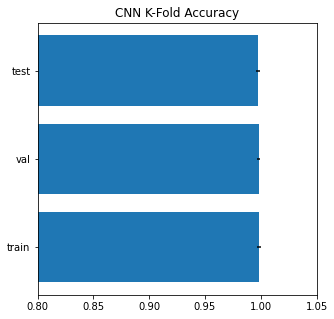

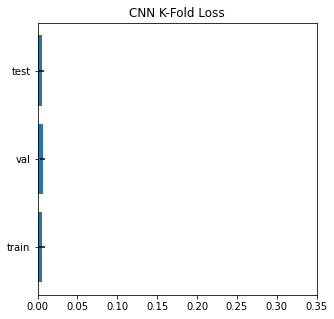

In [ ]:
kfold_plots(folds_results, path="CNN")

We are not much surprised to see that the results are great even when averaged among all the folds, to the point where plotting the scores of the various folds is almost pointless: every fold gave great results.

<h1>Predictions</h1>

Our predictor is so accurate that we can make an entire pass on the dataset and check which sample will be misclassified

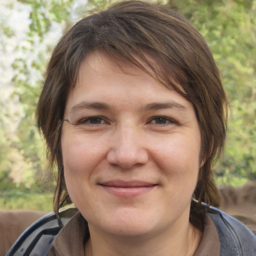

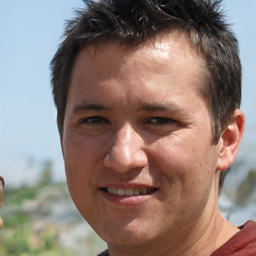

In [ ]:
errors = []
for i, x in enumerate(X):
  if Y[i] != (1.0 if cnn.predict(np.array([x]), batch_size=batch_size, workers=-1)[0][0]>=0.5 else 0.0) and (Y[i]==1.0 or Y[i]==0.0):
    errors.append(i)

for i in errors:
  k = len([x for x in set(range(5001)) - set(labeled) if x<=i+k])
  path = "faces-spring-2020/faces-spring-2020/face-" + str(i+k+1) + ".png"
  with Image.open(path) as img:
    display(img.resize((256, 256)))
  print("")

Only two errors on the entire dataset!

<h1>Conclusion</h1>

This work has shown that trying to predict if people generated by a GAN are wearing glasses or not is a quite challenging task if networks (in our case, MLPs) are only fed with the latent vectors used to generate the images. Maybe, having more data, we could build deeper networks without the arise of overfitting and hopefully increase the scores on the numerical dataset.<br>
Training on the actual images with CNNs, however, even without putting great effort into preprocessing and hyperparameter tuning, has proven to be very succesful, making us reach great scores even on unseen data and without requiring a very deep nor complex network.